In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/joerg/.pyvirtualenvs/py3-machine-learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/joerg/.pyvirtualenvs/py3-machine-learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Udacity Final Project: Identify Fraud from Enron Email

> Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

- ***POI***: an individual who was indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.



In [2]:
exec(open("poi_id.py").read())

## Overview of the Dataset and Removal of Outliers
The job of every good Data Analysts starts by understanding the task and the provided datasets.
This is a sample of the dataset in the form of a (Pandas-)table to illustrate the structure of the dataset.

In [3]:
df = pd.DataFrame.from_dict(data_dict_raw, orient='index')
HTML(df.head(3).to_html())

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,NaN,4175000.0,phillip.allen@enron.com,-126027.0,-3081055.0,1729541.0,13868.0,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,NaN
BADUM JAMES P,NaN,NaN,178980.0,182466.0,NaN,NaN,unknown,NaN,NaN,257817.0,3486.0,NaN,257817.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,NaN,NaN,james.bannantine@enron.com,-560222.0,-5104.0,5243487.0,56301.0,39.0,4046157.0,29.0,864523.0,0.0,False,NaN,465.0,1757552.0,NaN


In [4]:
print("Number of records: {}".format(len(data_dict_raw)))

Number of records: 146


In [5]:
print("Number of parameters: {}".format(len(df.columns)))

Number of parameters: 21


### List of parameters:

In [6]:
df.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

The label `POI` indicates, if a person has been identified as a ***Person Of Interest***. The other parameters provide information about salary, stock value and E-mail communication.

## Financial Data
The document `enron61702insiderpay.pdf` contains all the data and documentation.

![Enron Insider Pay](enron61702insiderpay_snap.png)

### Payments
1. `salary` Reflects items such as base salary, executive cash allowances, and benefits payments.
- `bonus`Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.
- `long_term_incentive` Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.
- `deferred_income` Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.
- `deferral payments` Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.
- `loan_advances` Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company.
- `other` Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft.
- `expenses` Reflects reimbursements of business expenses. May include fees paid for consulting services.
- `director_fees` Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.

### Stock Value
10. `exercised_stock_options` Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities.
- `restricted_stock` Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting
periods, regardless of whether deferred.
- `restricted_stock_deferred` Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.
(13) In 1998, 1999 and 2000, Debtor and non-debtor affiliates were charged for options granted. The Black-Scholes method was used to determine the amount to be
charged. Any amounts charged to Debtor and

## E-mail data
Some metadata about the E-mail communication of these persons is provided too:

In [7]:
print(features_email_stats)

['from_messages', 'from_this_person_to_poi', 'to_messages', 'from_poi_to_this_person', 'shared_receipt_with_poi']


## Quality Check of the Provided Dataset
Regarding the financial data, the parameters `total_payments` and `total_stock_value` may serve as a kind of checksum, i.e. to ensure the integrity of the dataset.

Unfortunately, there are at least

In [8]:
def checksum_df(df, cols, expected_sum):
    """Returns all rows that do not match expected_sum"""
    df[expected_sum[0]] = df[expected_sum[0]].fillna(0.0)
    df_wrong_checksum = df[df[cols].sum(axis=1)!=df[expected_sum[0]]]
    df_wrong_checksum = df_wrong_checksum[cols+expected_sum]
    df_wrong_checksum = df_wrong_checksum[df_wrong_checksum.any(axis=1)]
    return df_wrong_checksum

df_salary_wrong_checksum = checksum_df(df, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum))

2


rows, where `total_payments` does not sum up to the expected value.

These are the rows:

In [9]:
HTML(df_salary_wrong_checksum.to_html())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BELFER ROBERT,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0


The same problem is present for the `total_stock_value`, for this number of rows:

In [10]:
df_stock_wrong_checksum = checksum_df(df, features_financial_stock, features_financial_stock_total)
print(len(df_stock_wrong_checksum))

2


This table is showing the corrupt rows:

In [11]:
HTML(df_stock_wrong_checksum.head(5).to_html())

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
BELFER ROBERT,3285.0,NaN,44093.0,-44093.0
BHATNAGAR SANJAY,2604490.0,-2604490.0,15456290.0,0.0


Obviously, the quality of the provided data cannot be trusted. There may be two reasons for this:
1. The original data is already corrupt.
- The provided derived dataset is corrupt due to human mistake.

In case of human mistake, it is possible to check the values in `enron61702insiderpay.pdf`.
Apparently, the original document has different values for the suspicious records. So there is at least a few obvious human errors.

However, there might be many more errors, although the checksum is correct.

## Correction of the provided input dataset
In order to correct human error in the process, it is neccessary to compare the dataset row by row.

### Parsing the full table from `enron61702insiderpay.pdf`
is required, since this is the original document.

In [12]:
import re
import numpy as np

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
has_numbers_re = re.compile(r'[0-9]+')

# INSIDERNAME_re = re.compile(r'(^[A-Z .]+, [A-Z]+ [A-Z])|(^[A-Z]+, [A-Z]+)')
INSIDERNAME_re = re.compile(r'(^[A-Z .]+, [A-Z]+ [A-Z .]+)|(^[A-Z-]+, [A-Z]+)')
FOOTNOTE_re = re.compile(r'^\([a-z]\)')
NUMBER_re = re.compile(r'(^\(\$([0-9,_]+)\))|(^\(([0-9,_]+)\))|(^\$[0-9,]+)|(^[0-9,]+)')
# SPACES_re = re.compile(r'[^\S\n\t]+') # https://stackoverflow.com/questions/38162444/python-regex-match-space-only
SPACES_re = re.compile(r'^\ ') # https://stackoverflow.com/questions/38162444/python-regex-match-space-only

tablestr = "ALLEN, PHILLIP K   $1233,43423  ($999,9) $324,001BADUM JR., JAMES P  25,234,000 (d) (21,123) 435,325,455BERBERIAN, DAVID 235,111"

def check_re(robj, s):
    m = robj.search(s)
    if m:
        name = m.group()
        return name
    else:
        return None

def parse_row(s):
    rowelements = []
    row_incomplete = True
    space = 0
    while row_incomplete:
        footnote = check_re(FOOTNOTE_re, s)
        number = check_re(NUMBER_re, s)        
        if not s:
            break
        if s[0] == ' ':
            s = s.split(' ', 1)[1]
            space += 1
        elif footnote:
            s = s.split(footnote, 1)[1]
        elif number:
            s = s.split(number, 1)[1]
            number = float(int(number.replace("$","").replace(",","").replace("(","").replace(")","")))
            rowelements.append(number)
            #print(space)
            space = 0
        elif s[0] == '-':
            s = s.split('-', 1)[1]
            rowelements.append(np.nan)
            #print(space)
            space = 0            
        else:
            row_incomplete = False
    new_s = s
    return new_s, rowelements

def parse_table(tablestr):
    d = {}
    table_incomplete = True
    while table_incomplete:
        n = check_re(INSIDERNAME_re, tablestr)
        if n:
            #print("name found: {}".format(n))
            tablestr = tablestr.split(n, 1)[1]
            tablestr, row = parse_row(tablestr)
            if row:
                n = n.replace(",","").replace(".","")
                d.update({n:row})
            else:
                table_incomplete = False
            #print(tablestr)
        else:
            table_incomplete = False
    return d

# For testing the functions
#dd = parse_table(tablestr)
#print(tablestr)
#print(dd)


In [13]:
# https://automatetheboringstuff.com/chapter13/
import PyPDF2

pdfReader = PyPDF2.PdfFileReader(open('enron61702insiderpay.pdf', 'rb'))
pages = [0,1,2,3]
data_dict = {}
for page in pages:
    print("Parsing page #{}...".format(page))
    pageObj = pdfReader.getPage(page)
    text = pageObj.extractText()
    table = text.split("Total Stock Value",1)[1]
    dd = parse_table(table)
    data_dict.update(dd)

Parsing page #0...
Parsing page #1...
Parsing page #2...
Parsing page #3...


In [14]:
cols = features_financial_salary + features_financial_salary_total + features_financial_stock + features_financial_stock_total
df_pdf = pd.DataFrame.from_dict(data_dict, columns=cols, orient='index')
# Deferral items are negative...
df_pdf['deferred_income'] = -df_pdf['deferred_income']
df_pdf['restricted_stock_deferred'] = -df_pdf['restricted_stock_deferred']
#df_pdf['deferral_payments'] = -df_pdf['deferral_payments']

In [15]:
df_salary_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum_pdf))

2


In [16]:
HTML(df_salary_wrong_checksum_pdf.to_html())


,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0
YEAP SOON,NaN,55097.0,NaN,-55097.0,192758.0,NaN,NaN,192758.0,NaN,0.0


In [17]:
print(df_salary_wrong_checksum_pdf.to_csv())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BHATNAGAR SANJAY,,,,,,,137864.0,,137864.0,15456290.0
YEAP SOON,,55097.0,,-55097.0,192758.0,,,192758.0,,0.0



The few suspicious rows are due to missing delimiters in the original document.

The values are corrected "by hand". The number of incorrect checksum is now for `features_financial_salary_total`:

In [18]:
ff = features_financial_salary+features_financial_salary_total + features_financial_stock + features_financial_stock_total

In [19]:
bs=[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,137864.0, np.nan,137864.0, 15456290.0, 2604490.0, -2604490.0, 15456290.0]
ys = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 55097.0, np.nan, 55097.0, 192758.0, np.nan, np.nan, 192758.0]
df_pdf.loc['BHATNAGAR SANJAY'] = pd.Series(bs, index=ff)
df_pdf.loc['YEAP SOON'] = pd.Series(ys, index=ff)

In [20]:
df_salary_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum_pdf))

0


and for `features_financial_stock_total`:

In [21]:
df_stock_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_stock, features_financial_stock_total)
print(len(df_stock_wrong_checksum_pdf))

0


Finally, the following table shows all the rows from the new self-parsed dataset that are different from the provided dataset. Apparently, 9 errors in a dataset of less than 150 records is quite a big mess.

In [22]:
# https://stackoverflow.com/questions/19917545/comparing-two-pandas-dataframes-for-differences
def get_different_rows(source_df, new_df):
    """Returns just the rows from the new dataframe that differ from the source dataframe"""
    merged_df = source_df.merge(new_df, indicator=True, how='outer')
    changed_rows_df = merged_df[merged_df['_merge'] == 'right_only']
    return changed_rows_df.drop('_merge', axis=1)
#features_financial_salary+features_financial_salary_total #

df1 = df[ff].reset_index()
df2 = df_pdf[ff].reset_index()
df_diff12 = get_different_rows(df1, df2)
df_diff21 = get_different_rows(df2, df1)
HTML(df_diff12.to_html())

,index,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
146,BAXTER JOHN C,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,NaN,2660303.0,11200.0,NaN,5634343.0,6680544.0,3942714.0,NaN,10623258.0
147,BELFER ROBERT A,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,0.0
148,BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0
149,BLAKE JR NORMAN P,NaN,NaN,NaN,-113784.0,NaN,NaN,NaN,1279.0,113784.0,1279.0,NaN,NaN,NaN,0.0
150,DERRICK JR JAMES V,492375.0,800000.0,484000.0,-1284000.0,NaN,NaN,7482.0,51124.0,NaN,550981.0,8831913.0,1787380.0,-1787380.0,8831913.0
151,LAY KENNETH L,1072321.0,7000000.0,3600000.0,-300000.0,202911.0,81525000.0,10359729.0,99832.0,NaN,103559793.0,34348384.0,14761694.0,NaN,49110078.0
152,PEREIRA PAULO V FERRAZ,NaN,NaN,NaN,-101250.0,NaN,NaN,NaN,27942.0,101250.0,27942.0,NaN,NaN,NaN,0.0
153,WINOKUR JR HERBERT S,NaN,NaN,NaN,-25000.0,NaN,NaN,NaN,1413.0,108579.0,84992.0,NaN,NaN,NaN,0.0


These are the rows in the provided dataset that do not match the document:

In [23]:
HTML(df_diff21.to_html())

,index,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
144,BAXTER JOHN C,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,NaN,2660303.0,11200.0,NaN,5634343.0,6680544.0,3942714.0,NaN,10623258.0
145,BELFER ROBERT,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0
146,BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0
147,BLAKE JR. NORMAN P,NaN,NaN,NaN,-113784.0,NaN,NaN,NaN,1279.0,113784.0,1279.0,NaN,NaN,NaN,0.0
148,DERRICK JR. JAMES V,492375.0,800000.0,484000.0,-1284000.0,NaN,NaN,7482.0,51124.0,NaN,550981.0,8831913.0,1787380.0,-1787380.0,8831913.0
149,LAY KENNETH L,1072321.0,7000000.0,3600000.0,-300000.0,202911.0,81525000.0,10359729.0,99832.0,NaN,103559793.0,34348384.0,14761694.0,NaN,49110078.0
150,PEREIRA PAULO V. FERRAZ,NaN,NaN,NaN,-101250.0,NaN,NaN,NaN,27942.0,101250.0,27942.0,NaN,NaN,NaN,0.0
151,THE TRAVEL AGENCY IN THE PARK,NaN,NaN,NaN,NaN,NaN,NaN,362096.0,NaN,NaN,362096.0,NaN,NaN,NaN,0.0
152,TOTAL,26704229.0,97343619.0,48521928.0,-27992891.0,32083396.0,83925000.0,42667589.0,5235198.0,1398517.0,309886585.0,311764000.0,130322299.0,-7576788.0,434509511.0
153,WINOKUR JR. HERBERT S,NaN,NaN,NaN,-25000.0,NaN,NaN,NaN,1413.0,108579.0,84992.0,NaN,NaN,NaN,0.0


In [26]:
df_pdf.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
count,9.400000e+01,8.100000e+01,6.500000e+01,4.900000e+01,3.700000e+01,3.000000e+00,9.000000e+01,96.000000,15.000000,1.440000e+02,1.000000e+02,1.100000e+02,1.700000e+01,1.440000e+02
mean,2.840875e+05,1.201773e+06,7.464912e+05,-5.712835e+05,8.671188e+05,2.797500e+07,4.700610e+05,54533.312500,93234.466667,2.149476e+06,3.117640e+06,1.184748e+06,-4.456934e+05,3.017427e+06
std,1.771311e+05,1.441679e+06,8.629174e+05,9.347149e+05,1.297344e+06,4.638256e+07,1.404768e+06,46712.751852,33320.075521,8.779364e+06,5.657924e+06,2.217008e+06,6.934388e+05,6.271528e+06
min,4.770000e+02,7.000000e+04,6.922300e+04,-3.504386e+06,7.961000e+03,4.000000e+05,2.000000e+00,148.000000,17500.000000,0.000000e+00,9.803000e+03,3.246000e+04,-2.604490e+06,0.000000e+00
25%,2.118020e+05,4.250000e+05,2.750000e+05,-5.833250e+05,8.543000e+04,1.200000e+06,1.197000e+03,22140.500000,100017.000000,8.747150e+04,5.701288e+05,2.540180e+05,-4.095540e+05,2.563765e+05
50%,2.587410e+05,7.500000e+05,4.221580e+05,-1.440620e+05,2.274490e+05,2.000000e+06,3.857000e+04,46547.500000,103750.000000,9.138250e+05,1.310814e+06,4.517400e+05,-1.536860e+05,9.805345e+05
75%,3.086065e+05,1.200000e+06,8.318090e+05,-3.834600e+04,8.753070e+05,4.176250e+07,3.440270e+05,79252.250000,110895.000000,1.885158e+06,2.544450e+06,1.002370e+06,-8.278200e+04,2.372703e+06
max,1.111258e+06,8.000000e+06,5.145434e+06,-8.330000e+02,6.426990e+06,8.152500e+07,1.035973e+07,228763.000000,125034.000000,1.035598e+08,3.434838e+07,1.476169e+07,-3.246000e+04,4.911008e+07


Remove these persons, because they do not contribute with sufficient value. There is no POI included.

In [4]:
toomanynan = df.isna().sum(axis=1) > 16
df_toomanynan = df[toomanynan]
HTML(df_toomanynan.to_html())

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
GRAMM WENDY L,NaN,NaN,NaN,119292.0,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,119292.0
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
SCRIMSHAW MATTHEW,NaN,NaN,NaN,NaN,NaN,NaN,matthew.scrimshaw@enron.com,NaN,NaN,759557.0,NaN,NaN,759557.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
THE TRAVEL AGENCY IN THE PARK,NaN,NaN,NaN,362096.0,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362096.0,NaN,False,NaN,NaN,NaN,NaN
WHALEY DAVID A,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,98718.0,NaN,NaN,98718.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
WODRASKA JOHN,NaN,NaN,NaN,189583.0,NaN,NaN,john.wodraska@enron.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189583.0,NaN,False,NaN,NaN,NaN,NaN
WROBEL BRUCE,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,139130.0,NaN,NaN,139130.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


Who is *THE TRAVEL AGENCY IN THE PARK*?

There is one clear outlier in `data_dict_raw`. It's the sum over all data.

In [5]:
df

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,NaN,4175000.0,phillip.allen@enron.com,-126027.0,-3081055.0,1729541.0,...,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,NaN
BADUM JAMES P,NaN,NaN,178980.0,182466.0,NaN,NaN,unknown,NaN,NaN,257817.0,...,NaN,257817.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,NaN,NaN,james.bannantine@enron.com,-560222.0,-5104.0,5243487.0,...,39.0,4046157.0,29.0,864523.0,0.0,False,NaN,465.0,1757552.0,NaN
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,unknown,NaN,-1386055.0,10623258.0,...,NaN,6680544.0,NaN,2660303.0,NaN,False,1586055.0,NaN,3942714.0,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,frank.bay@enron.com,-82782.0,-201641.0,63014.0,...,NaN,NaN,NaN,69.0,NaN,False,NaN,NaN,145796.0,NaN
BAZELIDES PHILIP J,80818.0,NaN,684694.0,860136.0,NaN,NaN,unknown,NaN,NaN,1599641.0,...,NaN,1599641.0,NaN,874.0,NaN,False,93750.0,NaN,NaN,NaN
BECK SALLY W,231330.0,7315.0,NaN,969068.0,NaN,700000.0,sally.beck@enron.com,NaN,NaN,126027.0,...,144.0,NaN,4343.0,566.0,386.0,False,NaN,2639.0,126027.0,NaN
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,NaN,5249999.0,tim.belden@enron.com,NaN,-2334434.0,1110705.0,...,228.0,953136.0,484.0,210698.0,108.0,True,NaN,5521.0,157569.0,NaN
BELFER ROBERT,NaN,NaN,-102500.0,102500.0,NaN,NaN,unknown,44093.0,NaN,-44093.0,...,NaN,3285.0,NaN,NaN,NaN,False,NaN,NaN,NaN,3285.0
BERBERIAN DAVID,216582.0,NaN,NaN,228474.0,NaN,NaN,david.berberian@enron.com,NaN,NaN,2493616.0,...,NaN,1624396.0,NaN,NaN,NaN,False,NaN,NaN,869220.0,NaN


In [17]:
outliers = df['salary'] == df['salary'].max()
df_outliers = df[outliers]
HTML(df_outliers.to_html())

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
TOTAL,26704229.0,NaN,32083396.0,309886585.0,83925000.0,97343619.0,unknown,-7576788.0,-27992891.0,434509511.0,5235198.0,NaN,311764000.0,NaN,42667589.0,NaN,False,48521928.0,NaN,130322299.0,1398517.0


In [18]:
dd = pd.DataFrame.from_dict(my_dataset, orient='index')
print(dd.count())

salary                              138
to_messages                         138
deferral_payments                   138
total_payments                      138
loan_advances                       138
bonus                               138
email_address                       138
restricted_stock_deferred           138
deferred_income                     138
total_stock_value                   138
expenses                            138
from_poi_to_this_person             138
exercised_stock_options             138
from_messages                       138
other                               138
from_this_person_to_poi             138
poi                                 138
long_term_incentive                 138
shared_receipt_with_poi             138
restricted_stock                    138
director_fees                       138
fraction_from_poi_to_this_person    138
fraction_from_this_person_to_poi    138
dtype: int64


These datapoints are removed in `poi_id.py` at `### Task 2: Remove outliers`.

After the first step of data cleaning, there are 138 records left.

A lot of values are unknown/missing. Before the data is fed into the machine learning models they are filled with zeros.

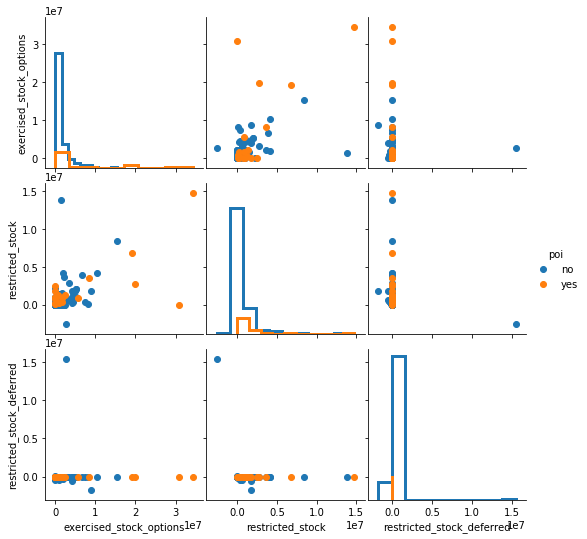

In [24]:
# https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
# https://seaborn.pydata.org/tutorial/axis_grids.html
df = df_pdf
df = pd.DataFrame.from_dict(my_dataset, orient='index') #.replace('NaN', np.nan) # Load cleaned dataset
df['poi'] = df['poi'].replace(True, 'yes')
df['poi'] = df['poi'].replace(False, 'no')
# features2plot = features_financial_salary+features_financial_stock + features_email + ['poi']
features2plot = features_financial_stock + ['poi']
df2plot = df[features2plot]
#df2plot = df2plot[~(df2plot.isna().sum(axis=1)>0)] # plot only existing data
#g = sns.pairplot(df2plot, hue="poi") # 

g = sns.PairGrid(df2plot, hue="poi")
#g = sns.PairGrid(df2plot, vars=df2plot.columns[~df2plot.columns.isin(['poi'])].tolist(), hue="poi")
#g = sns.PairGrid(df2plot, vars=df2plot.columns.tolist())
#g = g.map(plt.scatter)
g.fig.subplots_adjust(wspace=.02, hspace=.1);
#g.fig.subplots_adjust(wspace=.02, hspace=.02);
g = g.map_upper(plt.scatter)
g = g.map_diag(plt.hist, histtype="step", linewidth=3)
#g.map_diag(sns.kdeplot, lw=3, legend=False);
#g.map_lower(sns.kdeplot)
g = g.map_lower(plt.scatter)
g.add_legend()
#g.map_offdiag(plt.scatter)


Apparently, there are positive and negative values in the dataset, which is not reasonable at all. Comparing some random values with `enron61702insiderpay.pdf` it turned out, that there are many errors in the dataset.

In [27]:
poi_communicator = (df['fraction_from_poi_to_this_person'] + df['fraction_from_this_person_to_poi']).sort_values(ascending=False)
poi_communicator.index
HTML(df.loc[poi_communicator.index].head(5).to_html())
#df_outliers = df[outliers]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,fraction_from_poi_to_this_person,fraction_from_this_person_to_poi
HUMPHREY GENE E,130724.0,128.0,2964506.0,3100224.0,NaN,NaN,gene.humphrey@enron.com,NaN,NaN,2282768.0,4994.0,10.0,2282768.0,17.0,NaN,17.0,0.0,NaN,119.0,NaN,NaN,0.078125,1.000000
SHERRICK JEFFREY B,NaN,613.0,NaN,NaN,NaN,NaN,jeffrey.sherrick@enron.com,NaN,NaN,1832468.0,NaN,39.0,1426469.0,25.0,NaN,18.0,0.0,NaN,583.0,405999.0,NaN,0.063622,0.720000
DONAHUE JR JEFFREY M,278601.0,865.0,NaN,875760.0,NaN,800000.0,jeff.donahue@enron.com,NaN,-300000.0,1080988.0,96268.0,188.0,765920.0,22.0,891.0,11.0,0.0,NaN,772.0,315068.0,NaN,0.217341,0.500000
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,NaN,1500000.0,kevin.hannon@enron.com,NaN,-3117011.0,6391065.0,34039.0,32.0,5538001.0,32.0,11350.0,21.0,1.0,1617011.0,1035.0,853064.0,NaN,0.030622,0.656250
GARLAND C KEVIN,231946.0,209.0,NaN,1566469.0,NaN,850000.0,kevin.garland@enron.com,NaN,NaN,896153.0,48405.0,10.0,636246.0,44.0,60814.0,27.0,0.0,375304.0,178.0,259907.0,NaN,0.047847,0.613636


### Considerations about using the features `from_poi_to_this_person` and `from_this_person_to_poi`
Because they contain derived information about the POI which in turn is the label. In case we want to identify a new POI, at least, this values must be update for all records.

['poi', 'salary', 'bonus', 'exercised_stock_options', 'total_stock_value']


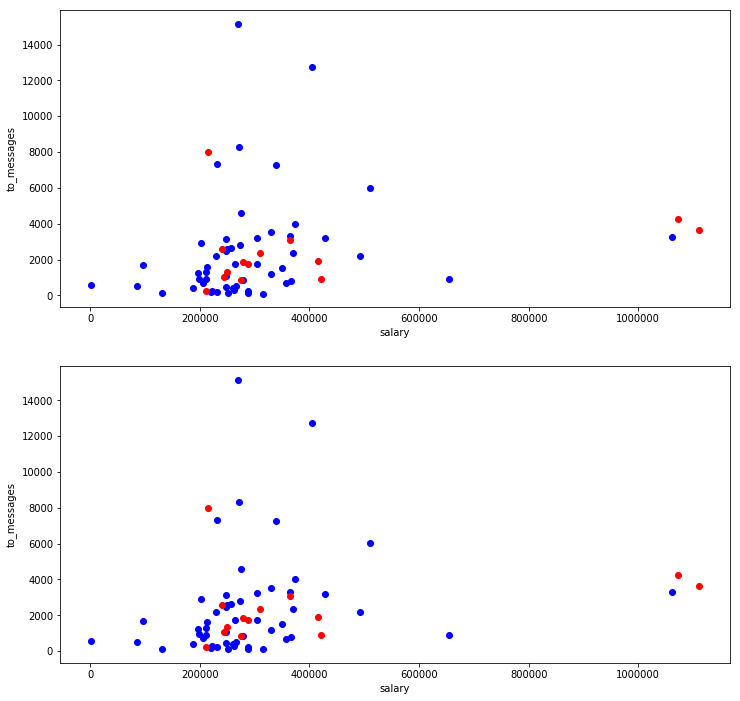

In [7]:

# fig, ax = plt.subplots()

def demo_plot_2features(ax, df):
    cols = df.columns[~df.columns.isin(['poi'])]
    def plot_s(d, color=None, label=None):
        X = d[cols[0]]
        Y = d[cols[1]]
        ax.plot(X,Y, 'o', marker='o', color=color)# color, label=label)
    d_npoi = df[df['poi'] == False]
    plot_s(d_npoi, color='blue', label='not POI')
    
    d_poi = df[df['poi'] == True]
    plot_s(d_poi, color='red', label='is POI')
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])

#fig = plt.figure(figsize=(12,9))
#(ax1, ax2, ax3) = fig.add_subplot(3, 1, 1)
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,12))
features2plot = ['poi'] + features_financial_basic + features_financial_stock
print(features2plot)
pnum = 2 #len(test_countries)
fig, ax = plt.subplots(pnum, figsize=(12,12))

for pos in range(pnum):
    demo_plot_2features(ax[pos], df)
    #ax[pos].plot([ testi[pos]['Median GDP per capita'], testi[pos]['GDP per capita'] ], [0,0], 'o')
#ax[pnum-1].set_xlabel("Categories (bins) of income in $")

plt.show()

In [18]:
print("Number of records in the dataset: {}".format(len(df.index)))

Number of records in the dataset: 146


The dataset contains 146

> What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

> What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

>  What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

> What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

> Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]